In this tutorial session, we will explore how to model sequential data using recurrent neural networks (RNNs). In the first part, we will build an intuition on some moving parts of RNNs on a toy problem. The second part of the tutorial will showcase an example of applying RNNs to the more realistic textual data.

Here we will use [Pytorch](https://colab.research.google.com/drive/1y9raF4S_HM3XU8e6es5j_l0WerKTQJeu#scrollTo=9OpW6mo6Nwgy&line=1&uniqifier=1) library, which is a popular open-source library that provides many convenient tools for building artificial neural networks. 

# Part 1: simple example (learning a sine wave)

In [955]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
torch.manual_seed(2024)
np.random.seed(2024)

%matplotlib inline
import matplotlib.pyplot as plt

Les start with generating some data!

In [956]:
def generate_sinus_wave(train_len, valid_len):
  time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
  data = np.sin(time_steps)

  xs = data[:train_len-1]
  ys = data[1:train_len] # as discussed in class, targets are shifted by 1 step

  train_x = torch.Tensor(xs).view(-1, 1, 1)
  train_y = torch.Tensor(ys)
  return data, time_steps, train_x, train_y

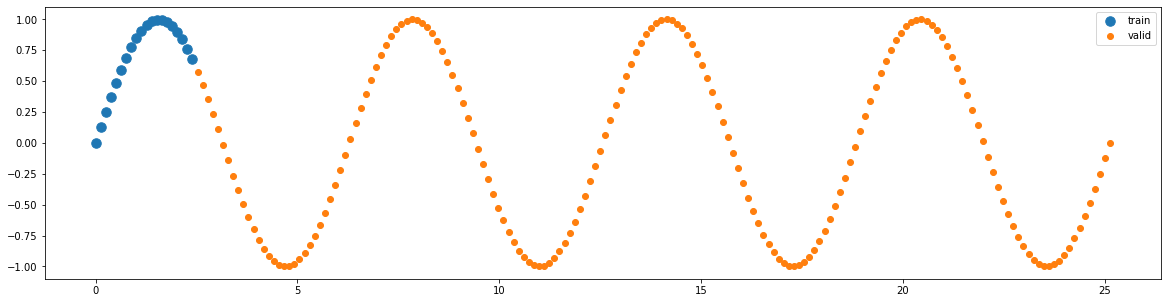

In [957]:
seq_length = 200 #total sequence length
portion_train =0.1 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

We formulate the task as predicting the next point given the input sequence sofar. We, therefore, need to shift out targets by one as mentioned in the class. Here is a closer look at our input and target data.

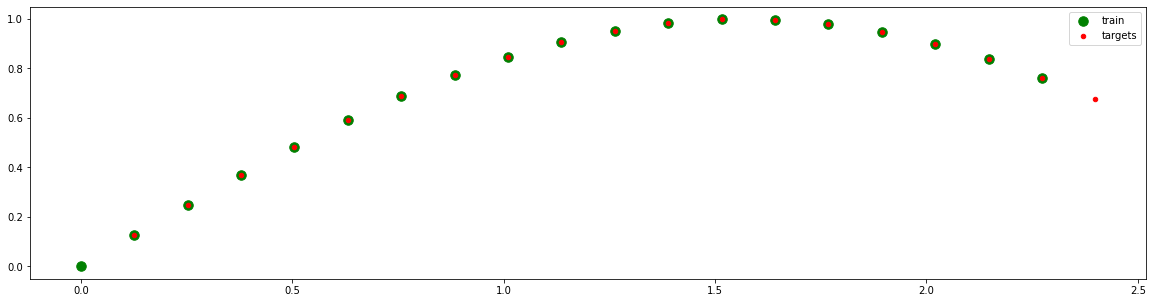

In [958]:
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[1:train_len], train_y, s=20, c='r', label='targets')
ax.legend()

We will use data generated from a sine curve for our toy sequential prediction problem. Namely, given some part of the sequence as training data (blue points in the visualization above), our model will be tasked to generate the rest of the sequence (orange points).

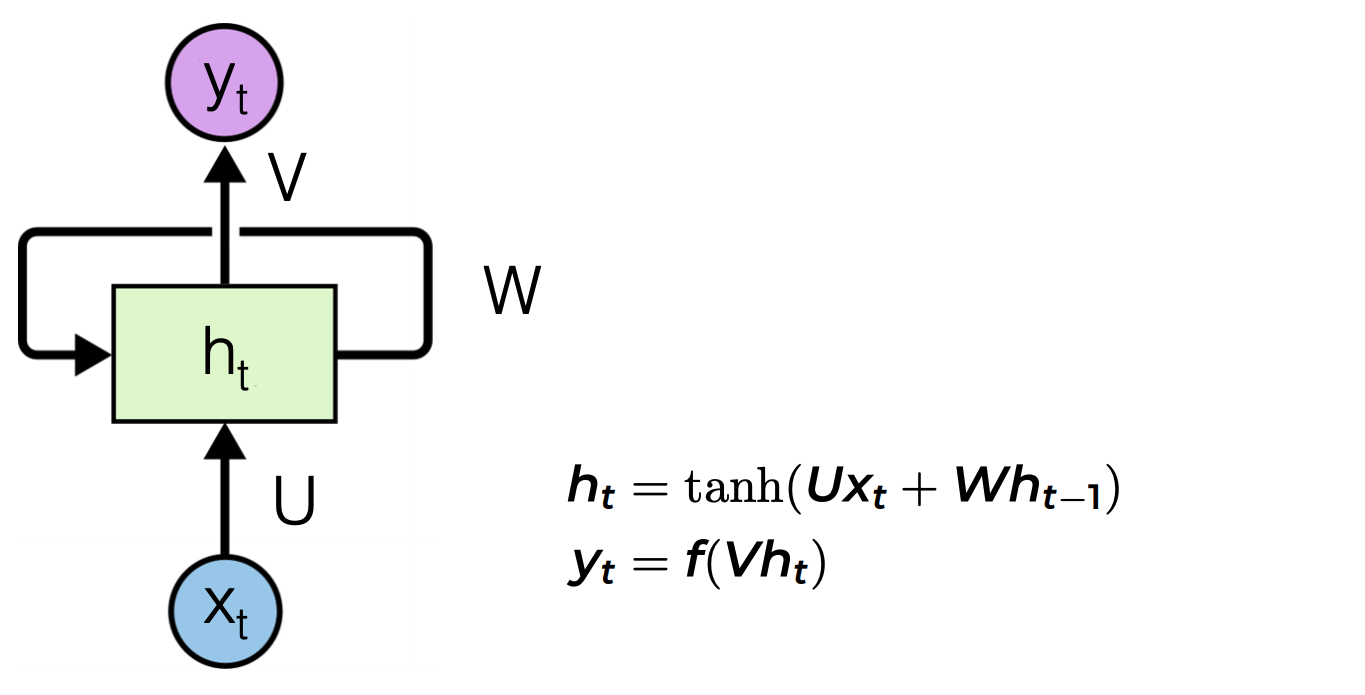

As we have seen in class, a simple recurrent network cell takes the current input at time step t ($X_t$) and produces an output ($y_t$) and a new hidden state that is passed to through a recurrent connection to the calculation at the next time step (in the figure above the recurrent connection uses weights W).

Lets first implement this simple RNN cell using Pytorch. Noe, we will replace the $tanh$ activation with $sigmoid$ (covered in the previous tutorial), as it produced better empirical results for the sine wave task (yes, Deep Learning is a very empirical field).

As you might recall from the previous lecture on feed-forward neural networks, the second equation in the figure above ($y_t = f(Vh_t)$) looks very similar to a layer in a feedforward neural network. Indeed it is one, where $V$ denotes our learnable weighted and $f$ is our activation function. Pytorch already provides us with an implementation of such a layer. We will add it outside of our simple RNN cell for convenience.


In [959]:
class RNN_Cell(nn.Module): 
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size)) #we will randomly innitialize out trainable parameters
        self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))

        self.b = torch.nn.Parameter(torch.randn(hidden_size))

    def forward(self, x_t, state):

        h_prev = state

        #here, we simply write down the equations from the figure above in the pytorch 'language'
        a = torch.mm(x_t, self.U) + torch.mm(h_prev, self.W) + self.b
        h = torch.sigmoid(a)

        return h

Now, having implemented our simple recurrent cell, we need to put cells together to form a network. 

Remember the principle of RNNs? The same(!) cell is used repeatedly receiving the new $X_t$ and the previous hidden state as input.

 We will also add our missing feed-forward layer (equation $y_t = f(Vh_t)$) here (we will set $f$ to identity, since we dont need any additional activation function here).

In [960]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn_cell = RNN_Cell(input_dim, hidden_size)
        self.linear = nn.Linear(hidden_size, 1) # here is out missing equation from before, in Torch the feed-forward layers are called Linear

    def init_hidden(self,):
        return torch.zeros(1,self.hidden_size) #we will initialize our hidden state with zeros
    
    def forward(self, X, h=None):
        self.h = self.init_hidden() if h is None else h
        outputs = []

        # we will process the sequence here
        for X_t in X:

            self.h = self.rnn_cell.forward(X_t, self.h)

            y_t = self.linear.forward(self.h)
            outputs.append(y_t)

        return torch.stack(outputs), self.h

**Question 1 (RNNs)** : in the standard feed-forward neural network, all the training and test samples are considered independently. Can you explain how this can be a bad fit for sequential data modeling like stock market prediction or sequential sine curve fitting?

In which line of code in the $forward$ function in the previous cell do we explicitly break the assumption of data samples in the sequence being independent from each other?

Answer: as for a trader, historical data is a major deciding factor for making a prediction, also a machine learning model should model this dependency. This is explicitly modeled in out code in the line:

```
self.hx = self.rnn_cell.forward(X_t, self.hx)
```
where we path the previous hidden state as input to the computation performed by the recurrent cell at the current time step.

**Question 2 (RNNs)**: given your answers to the previous question, can you explain in your own words, which role the hidden state ($h$) plays in RNNs?

Answer: hidden state carries the information about the input sequence preceeding the current time step. E.g. in the sine curve example it encodes the values of the preceding inputs, which can is essential for the prediction at the current time step (whether the next point in the sequence will be below or above the current one depends on the previous points).





Okay, we have implemented the 'forward path' of our RNN model. But what about the actual learning. The learning algorithm that is usually used to train RNNs is called [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time). Don't be afraid of the fancy name though, the essential idea that underlines this and many other learning algorithms for the deep neural network is just repeatedly applying the chain rule of differentiation: 

if $F = f(y), y = g(x)$, we have that $ \frac{dF}{dx} = \frac{dF}{dy} \frac{dy}{dx}  $ (given f and g are differential functions).

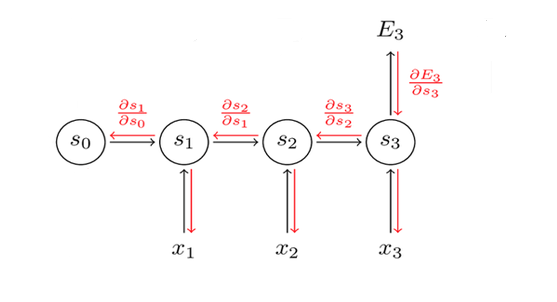

The above image depicts a simple RNN with 3 states. Lets put it into mathematical equations ignoring the activation functions (and assuming our learnable weights are just scalars).

$s_1 = w x_1 + u s_0$

$s_2 = w x_2 + u s_1$ 

$s_3 = w x_3 + u s_2$ 

Suppose we are dealing with a regression problem, let's include a simple L2 loss:

$E = \frac{1}{2} (s_3 - y)^2 $, where $y$ is the ground truth.

**Question 3 RNNs (Bonus)** : write down equations for the backpropagation through time for states $s_1$, $s_2$ and $s_3$ (hint: simply use chain-rule starting from the error term).

Answere: 

$\frac{dE}{ds_3} = s_3 - y $

$ \frac{dE}{d_2} = (s_3 - y) * \frac{ds_3}{ds_2} = u (s_3 - y) $

$ \frac{dE}{d_1} = u (s_3 - y) * \frac{ds_2}{ds_1} = (s_3 - y) u^2 $




Dont worry, we are ot going to write down the backpropagation equations by hand, Pytorch will do the hard work of differentiation for us. 

Finally, lets now train our simple RNN on the input sequence generated previously.

In [961]:
hidden_size = 10
learning_rate = 0.01


In [962]:
model = RNN(1,hidden_size) #first we instantiate our model

criterion = nn.MSELoss() #we are using means squered error as loss function here
optimizer = optim.Adam(model.parameters(), learning_rate) # this will set-up an optimizer for parameter updates, feel free to ignore this for now!

epochs = 300 #one epoch corresponds to a single pass throug our training data
for epoch in range(epochs):
    optimizer.zero_grad()
    
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.9153075218200684
Epoch 10: loss 0.057742588222026825
Epoch 20: loss 0.09892739355564117
Epoch 30: loss 0.04026683047413826
Epoch 40: loss 0.04482607915997505
Epoch 50: loss 0.03448859229683876
Epoch 60: loss 0.03226882219314575
Epoch 70: loss 0.02791777066886425
Epoch 80: loss 0.02395046502351761
Epoch 90: loss 0.019819926470518112
Epoch 100: loss 0.015079578384757042
Epoch 110: loss 0.009353461675345898
Epoch 120: loss 0.005761703941971064
Epoch 130: loss 0.0045156111009418964
Epoch 140: loss 0.00402419175952673
Epoch 150: loss 0.0037884730845689774
Epoch 160: loss 0.0036477302201092243
Epoch 170: loss 0.0035232501104474068
Epoch 180: loss 0.0033933869563043118
Epoch 190: loss 0.0032601275015622377
Epoch 200: loss 0.003118521999567747
Epoch 210: loss 0.00295039894990623
Epoch 220: loss 0.0027070101350545883
Epoch 230: loss 0.0023161459248512983
Epoch 240: loss 0.0018708353163674474
Epoch 250: loss 0.0014890257734805346
Epoch 260: loss 0.0011142552830278873
Epoch 270: l

Let's see how our trained model can resemble the training sequence. Given a point from our training data (time $t$), we will ask our model to generate the next point ($t+1$), one point at a time. We will carry over the hidden state along the sequence generation.

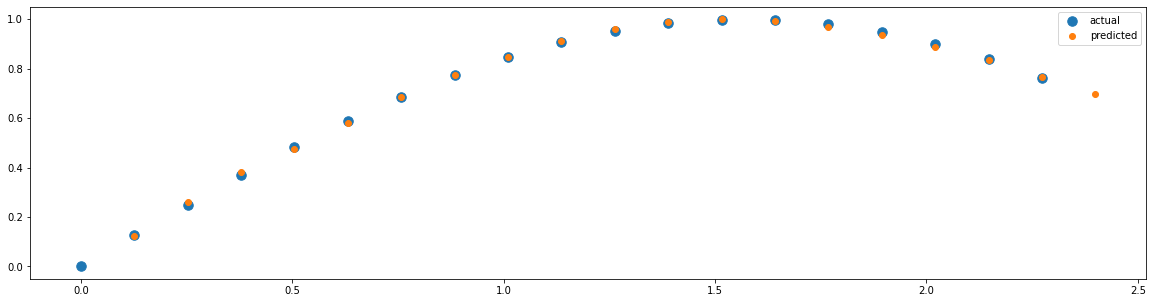

In [963]:
def make_predictions_train(model):
  predictions = []
  hidden_prev = None
  # we will go over all points in out training sequence
  for i in range(train_x.shape[0]):
      input = train_x[i]
      input = input.view(1, 1, 1)
      
      #we will give the current (single) point and the (current) hidden state as input to our model
      pred, hidden_prev = model(input, hidden_prev)
      predictions.append(pred.data.numpy()[0][0])
  return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model)

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend()

As we can see in the plot above, that our model has learned to fit the input sequence almost perfectly.

But what about the unseen part of the sequence? 

In [964]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
  predicts=[]
  input = torch.Tensor(starting_point).view(1,1,1)
  for i in range(length):
    pred, hidden_state = model(input, hidden_state)
    predicts.append(pred.data.numpy()[0][0])
    input = pred
  return predicts


Let's generate the part of the sequence which was hidden from the model at training. Note, from the model's perspective, it is like generating completely new unseen data. If our data was e.g. text instead of a simple sine wave, we could ask our model to generate a completely new text, isn't that cool?

Note, to generate unsee part of the sequence:
- we will first condition on the last point from the seen sequence, and ask the model to generate a new point
- then we will pass this newly generated point and the new hidden state as input and ask the model to generate a new point and so on... in theory we could generate an infinitely long sequence.

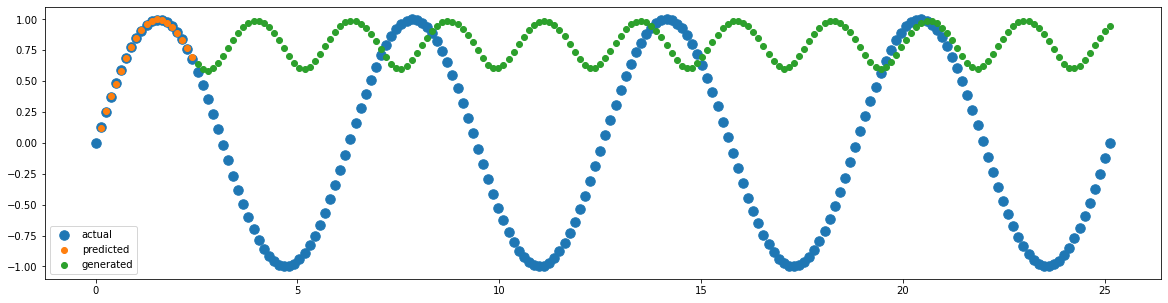

In [965]:
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

As can be seen in the plot above, our model's performance is quite poor when it comes to generating the unseen part of the sequence. 

Looking at our training sequence (the orange part in the plot above), does it contain the information needed to be able to generate the rest of the sine wave? Well, even as a human, if you had never seen a sine wave before, you probably would not be able to learn what a sine wave is solely from observing half of the cycle length of a sine wave.

**Question 4 (RNNs)**: try increasing the training sequence length ($portion\_train$) in the code snippet below. (hint: set the training length such that it includes at least one complete cycle of the sine wave)

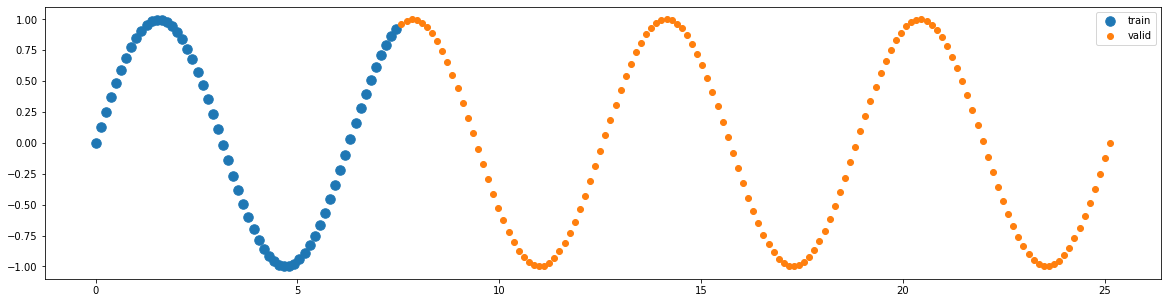

In [966]:

portion_train = 0.3 #Question: try out a longer training sequence to cover at least one period

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len

data, time_steps, train_x, train_y = generate_sinus_wave(train_len = train_len, valid_len = valid_len)

fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

Lets train our model again and see the result.

In [967]:
model = RNN(1,hidden_size)
optimizer = optim.Adam(model.parameters(), learning_rate)
epochs = 500 #
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.5011032819747925
Epoch 10: loss 0.2817438840866089
Epoch 20: loss 0.14002126455307007
Epoch 30: loss 0.04591163620352745
Epoch 40: loss 0.034373629838228226
Epoch 50: loss 0.01957571506500244
Epoch 60: loss 0.015781220048666
Epoch 70: loss 0.011615609750151634
Epoch 80: loss 0.009574676863849163
Epoch 90: loss 0.007917026989161968
Epoch 100: loss 0.006700701080262661
Epoch 110: loss 0.005720979999750853
Epoch 120: loss 0.004901386331766844
Epoch 130: loss 0.00420383270829916
Epoch 140: loss 0.0035910196602344513
Epoch 150: loss 0.0030460646376013756
Epoch 160: loss 0.0025531642604619265
Epoch 170: loss 0.0021111820824444294
Epoch 180: loss 0.0017363146180287004
Epoch 190: loss 0.0014513462083414197
Epoch 200: loss 0.0012457745615392923
Epoch 210: loss 0.0010832177940756083
Epoch 220: loss 0.0009477764251641929
Epoch 230: loss 0.0008383637759834528
Epoch 240: loss 0.0007509870338253677
Epoch 250: loss 0.0006797972018830478
Epoch 260: loss 0.0006202268414199352
Epoch 270:

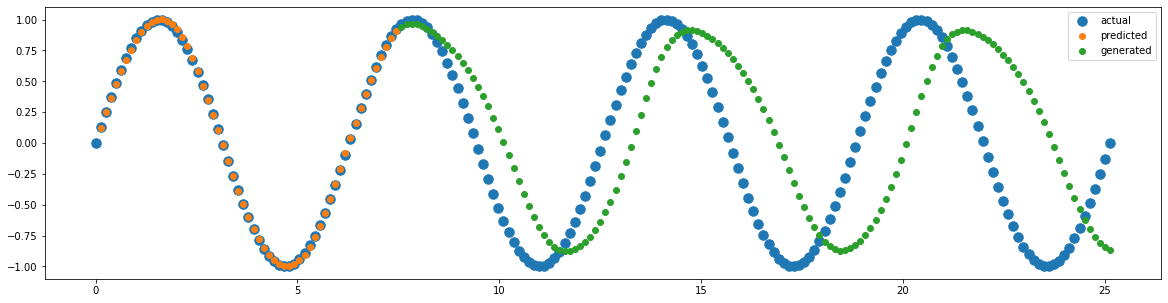

In [968]:
#get training data predictions
predictions_train, hidden_prev = make_predictions_train(model)
#generate unsee points
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)
#concatenate two lists
predictions = predictions_train+generated_points 
#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

And voilà, our new model could now better capture the periodic nature of the sine wave. 

Note, you might re-run the training for several times and observe that each time you get a different result. This is due to the random reinnitialization of the trainable weight in our RNN cell each time you restart training (re-instantiate the network object):

```
self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size)) 

self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
```


We certainly could try to get some better results by either:
- further hyperparameter tuning
- extending the training sequence length (MORE DATA is always good)

These are valid stretagies often used in deep learning to improve the performance of the models. Yet, manytimes the real innovations comes from the algorithm design. 

So lets try to replace out simple RNN cell with a better cell - an LSTM cell. As mentioned in class, LSTM cells are better in 'remembering' long term dependencies in the data. Please, refer to this [blong article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) to see how LSTMS are different from the standard RNNs.

In [969]:
class RNN_wLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN_wLSTM, self).__init__()

        self.hidden_size = hidden_size

        ### NEW CELL ###  
        #we will use the pytorch implementation of the LSTM cell
        self.rnn_cell = nn.LSTMCell(1, hidden_size)
        ################

        self.linear = nn.Linear(hidden_size, 1) # here is out missing equation from before, in Torch the feed-forward layers are called Linear

    def init_hidden(self,):
        return (torch.zeros( 1, self.hidden_size),  torch.zeros( 1, self.hidden_size))
    
    def forward(self, X, h=None):
        self.h = self.init_hidden() if h is None else h
        outputs = []

        # we will process the sequence here
        for X_t in X:
            self.h = self.rnn_cell(X_t, self.h)

            y_t = self.linear.forward(self.h[0])
            outputs.append(y_t)

        return torch.stack(outputs), self.h

In [970]:
model = RNN_wLSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), 0.1)
epochs = 300
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.4571819305419922
Epoch 10: loss 0.02077229507267475
Epoch 20: loss 0.0051821027882397175
Epoch 30: loss 0.0018560857279226184
Epoch 40: loss 0.0006809889455325902
Epoch 50: loss 0.000273544283118099
Epoch 60: loss 9.821377898333594e-05
Epoch 70: loss 4.087547858944163e-05
Epoch 80: loss 3.4501405025366694e-05
Epoch 90: loss 2.0560397388180718e-05
Epoch 100: loss 1.4013486179464962e-05
Epoch 110: loss 1.0518943781789858e-05
Epoch 120: loss 8.599742614023853e-06
Epoch 130: loss 7.298215678019915e-06
Epoch 140: loss 6.521822342619998e-06
Epoch 150: loss 5.980529749649577e-06
Epoch 160: loss 5.55495989829069e-06
Epoch 170: loss 5.199027327762451e-06
Epoch 180: loss 4.887363957095658e-06
Epoch 190: loss 4.608305516740074e-06
Epoch 200: loss 4.355061264504911e-06
Epoch 210: loss 4.123279722989537e-06
Epoch 220: loss 3.909911356458906e-06
Epoch 230: loss 3.712764510055422e-06
Epoch 240: loss 3.529885134412325e-06
Epoch 250: loss 3.3597702895349357e-06
Epoch 260: loss 3.2011948

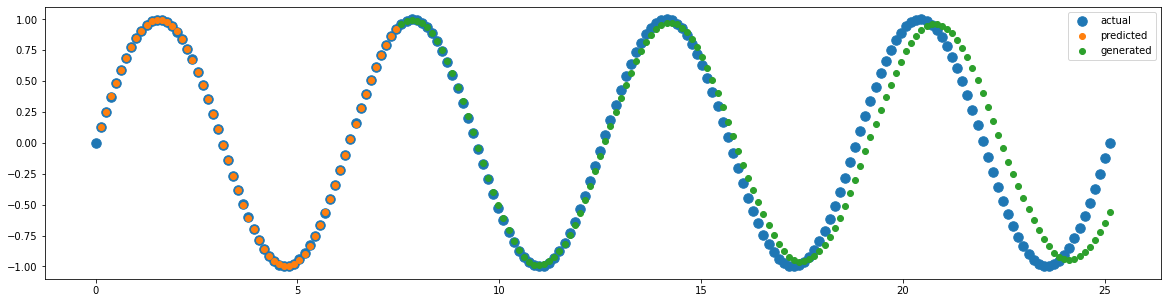

In [971]:
#get training data predictions
predictions_train, hidden_prev = make_predictions_train(model)
#generate unsee points
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)
#concatenate two lists
predictions = predictions_train+generated_points 
#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

As can be seen in the plot above, LSTMs can much better capture the period length and the amplitude of our wave and are more robust (converges consistently to a better result if you run training for everal times).

# Part two: language modeling



Lets have a look on mode complex task of language generation now. We will build an RNN that will generate text one character at a time (this part largely relies on the tutorial pugt together by Yen-Ling Kuo and Eugenio Piasini that can be found [here](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=dRNYHWwYyd4Q)). First, lets download our training data, which consists of Shakespear's texts.


In [ ]:
input_file = 'input.txt'
!if [ ! -f $input_file ]; then wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt; fi

--2020-10-06 12:47:33--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.08s   

2020-10-06 12:47:33 (12.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



We will write a function that will generate random chunks of text as input sequences to our RNN.

In [ ]:

!pip3 install unidecode

import random
import unidecode

file = unidecode.unidecode(open('input.txt').read())

def random_chunk(chunk_len=200):
    start_index = random.randint(0, len(file) - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]
  

     |████████████████████████████████| 245kB 3.3MB/s 


Lets have a look on some random input sequence.

In [ ]:
print(random_chunk())

here at night:
I'll to him; he is hid at Laurence' cell.

JULIET:
O, find him! give this ring to my true knight,
And bid him come to take his last farewell.

FRIAR LAURENCE:
Romeo, come forth; come for


We will convert words to integer indexes such that each character has a unique id.

We also provide a function to produce a random training sequence. The input is the character at time $t$. The target is the expected character to see at $t+1$.

In [ ]:
import string

# Turn string into list of longs
def char_tensor(str, print_=False):
    tensor = torch.zeros(len(str), 1).long()
    for c in range(len(str)):
        tensor[c][0] = string.printable.index(str[c])
        if print_:
          print(f"Character: {str[c]} gets index {tensor[c][0]}")
    return tensor

char_tensor('Hello, how are you?', print_=True)

def random_train_data():    
    chunk = random_chunk()
    input = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return input, target

Character: H gets index 43
Character: e gets index 14
Character: l gets index 21
Character: l gets index 21
Character: o gets index 24
Character: , gets index 73
Character:   gets index 94
Character: h gets index 17
Character: o gets index 24
Character: w gets index 32
Character:   gets index 94
Character: a gets index 10
Character: r gets index 27
Character: e gets index 14
Character:   gets index 94
Character: y gets index 34
Character: o gets index 24
Character: u gets index 30
Character: ? gets index 82


Now, we will set up the model.

This model will take as input the character for time step $t$ and is expected to output the character at $t+1$. There are three layers - one embedding layer that encodes the input character into a dense vector, one recurent layer that operates on that dense vector and a hidden state, and a decoder layer that outputs the probability distribution over all possible characters.

Note, we will use a [GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit) cell here, which is another variation of recurent cell similar to LSTM.


In [ ]:
class ShakespeareRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(ShakespeareRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.embeding_size = 6
        
        self.embedding = nn.Embedding(len(string.printable), self.embeding_size) 
        self.rnn = nn.GRU(self.embeding_size, hidden_size, num_layers=n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def init_hidden(self):
         return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def forward(self, input, hidden):
        x = self.embedding(input)
        x, hidden = self.rnn(x.view(1,1,x.size(-1)), hidden)
        output = self.decoder(x)
        tag_scores = F.log_softmax(output[-1], dim=1)
        return output, hidden

In [ ]:
def evaluate(model, prime_str='A', predict_len=100):
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    input = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(input, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        input = char_tensor(predicted_char)

    return predicted

It's time to train our model!

In [ ]:
n_characters = len(string.printable)
hidden_size = 100
n_layers = 2

epochs = 2000
lr = 0.005

model = ShakespeareRNN(n_characters, hidden_size, n_characters, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    loss = 0
    input, target = random_train_data()
    chunk_len = len(input)
    hidden = model.init_hidden()

    model.zero_grad()
    for x,y in zip(input, target):
      out, hidden = model(x, hidden)
      loss += criterion(out[-1], y)
    
    loss.backward()
    optimizer.step()

    loss = loss.item() / chunk_len
    if epoch % 100 == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / epochs * 100, loss))
        print(evaluate(model, 'Wh', 100), '\n')

[(0 0%) 4.5861]
WhOG`Oq[IYosyL;;
'p?U|X~gt)DLdD)q(bE743y.WJoC;{O;(6x}D+V9:EKppJCGA-o&Q 

[(100 5%) 3.0537]
Whiceoaw asodh tf nkyt iaO sOh yeone 
tlasoy
fO lf hd hte  Ey ne fd iRun fheGnn's OvdiGnnynse csol Etk 

[(200 10%) 2.9387]
Wh.:
voARu
Ecirveve, oroO
sElicS'ds nis,womomaAyht't
EI
cNF unan E de toAiERn alLfivo, ap
llouvoMLosov 

[(300 15%) 2.5575]
Why, gormechelwe ha lalic, foif:d, renht Irrueisy masif wath, gerd berent,the:
Natem the i rowe
Ond be 

[(400 20%) 2.4142]
Wh ser cofremt 
IOIU:
Ch ther Pe cheud; hnet canit,
Mhe watler-e!tirthh are the sherger?

KIICCAS: twe 

[(500 25%) 2.2452]
Whe hheses a I roard pell
lere roch ant tho dath On me aneaar fmilfapyft bell shess'd, So yate hatht s 

[(600 30%) 2.2465]
Wh ary an the lowtattith thery ar herres you, and onceln and He sain hise thik?

sIACER' Ky oith crone 

[(700 35%) 2.0160]
Whes
ele poths prinifrdor astoch youke sord a'tor croneave'

MEXkINTAmt as to
Is ae.

SACIUCITOND:
Oyf 

[(800 40%) 2.0914]
Whus dast,:
Shsangs om'

Lets use out model to generate some text conditionaning on different starting sequences:

In [ ]:
print(evaluate(model, 'Wh', predict_len=100), '\n')

Whurough? As Is,
My buts Meminn! Theed:
I'll such me such hast: I conter upuetang
ATel's mans ovenent  



In [ ]:
print(evaluate(model, 'How', predict_len=100), '\n')

Howe.; qece a Ewaty I thesusoped is hand:
that is Tothace whas heage,
Gan so ho heart?l no darfient onh 



In [ ]:
print(evaluate(model, 'JULIET', predict_len=100), '\n')

JULIET:
My croudners, dust I hidss out, and you bouried and to to repeny nour.

NOPEY:
Yither heoks and ea 

